In [2]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class MODEL_TYPES:
    LOG = "log" # beta[0] * log(x+beta[1]) + beta[2]
    INVERSE = "inverse" # beta[0] / (x+beta[1]) + beta[2]

class NOISE_TYPES:
    COUNT = "count" # fxn( x+noise )
    NEURAL = "neural" # fxn( x ) + noise

class SymbolicModel:
    def __init__(self, model_type=MODEL_TYPES.LOG,
                       betas=[1,1,1],
                       noise_stds={
                           NOISE_TYPES.COUNT: 1,
                           NOISE_TYPES.NEURAL: 1}):
        """
        Args:
            model_type: str ("log" or "inverse")
                the form of the model spacing.
                    "log":     -beta[0] * log(beta[1]*x+beta[2]) + beta[3]
                    "inverse": beta[0] / (beta[1]*x+beta[2]) + beta[3]
            betas: list of floats
                the parameters for the model
            noise_stds: dict
                "neural": float
                    the standard deviation of the outer gaussian noise
                    i.e. fxn( x ) + noise
                "count": float
                    the standard deviation of the inner gaussian noise
                    i.e. fxn( x + noise )
        """
        self.model_type = model_type
        self.betas = betas
        self.noise_stds = noise_stds

        if self.model_type == MODEL_TYPES.LOG:
            self.increment = self.log_fxn
            self.inverse = self.log_inverse
        elif self.model_type == MODEL_TYPES.INVERSE:
            self.increment = self.inv_fxn
            self.inverse = self.inv_inverse

    def log_fxn(self, x):
        """
        Args:
            x: ndarray float (m, n, ...)

        Returns:
            log_x: ndarray float (m, n, ...)
        """
        if NOISE_TYPES.COUNT in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.COUNT],
                size=x.shape
            )
            x = x + noise
        beta = self.betas
        log_x = - beta[0] * np.log(beta[1]*x + beta[2]) + beta[3]
        log_x[(log_x!=log_x)|(x<=0)] = 0
        if NOISE_TYPES.NEURAL in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.NEURAL],
                size=log_x.shape
            )
            log_x = log_x + noise
        return log_x

    def inv_fxn(self, x):
        """
        Args:
            x: ndarray float (m, n, ...)

        Returns:
            inv_x: ndarray float (m, n, ...)
        """
        if NOISE_TYPES.COUNT in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.COUNT],
                size=x.shape
            )
            x = x + noise
        beta = self.betas
        inv_x = beta[0] / (beta[1]*x + beta[2]) + beta[3]
        inv_x[(inv_x!=inv_x)|(x<=0)] = 0
        if NOISE_TYPES.NEURAL in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.NEURAL],
                size=inv_x.shape
            )
            inv_x = inv_x + noise
        return inv_x

    def log_inverse(self, log_x):
        """
        Inverts the log_fxn

        Args:
            log_x: ndarray float (m, n, ...)

        Returns:
            x: ndarray float (m, n, ...)
        """
        if NOISE_TYPES.NEURAL in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.NEURAL],
                size=log_x.shape
            )
            log_x = log_x + noise
        beta = self.betas
        x = (np.exp((log_x-beta[3])/(-beta[0]))-beta[2])/beta[1]
        if NOISE_TYPES.COUNT in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.COUNT],
                size=x.shape
            )
            x = x + noise
        return x

    def inv_inverse(self, inv_x):
        """
        Inverts the inv_fxn

        Args:
            inv_x: ndarray float (m, n, ...)

        Returns:
            x: ndarray float (m, n, ...)
        """
        if NOISE_TYPES.NEURAL in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.NEURAL],
                size=inv_x.shape
            )
            inv_x = inv_x + noise
        beta = self.betas
        x = ( beta[0]/(inv_x-beta[3]) - beta[2] )/beta[1]
        if NOISE_TYPES.COUNT in self.noise_stds:
            noise = np.random.normal(
                scale=self.noise_stds[NOISE_TYPES.COUNT],
                size=x.shape
            )
            x = x + noise
        return x

    def __call__(self, x):
        return self.increment(x)#Encodes from count space to neural space

    def decode(self, x):
        return self.inverse(x) #Inverts from neural space to count space


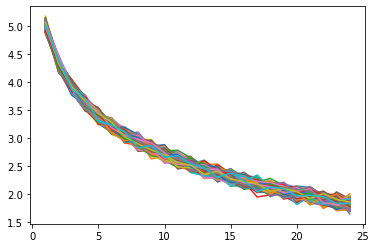

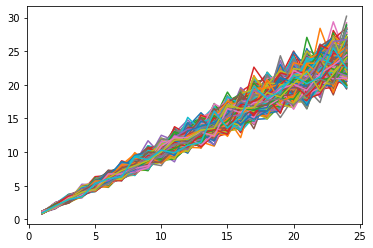

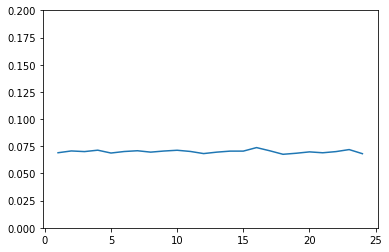

In [4]:
# Tests
model_type = MODEL_TYPES.LOG
betas = [1, 1, 0, 5]
target_nums = np.arange(1,25)
n_samps = 1000

model = SymbolicModel(
    model_type=model_type,
    betas=betas,
    noise_stds={
        "neural": 0.05,
        "count":  0,
    },
)
outputs = []
for i in target_nums:
    outputs.append(model(np.zeros(n_samps)+i))
plt.plot(target_nums, outputs)
plt.show()

revs = []
for output in outputs:
    revs.append(model.decode(output))
plt.plot(target_nums, revs)
plt.show()

cofv = [x.std()/x.mean() for x in revs]

plt.plot(target_nums, cofv)
plt.ylim([0,0.2])
plt.show()

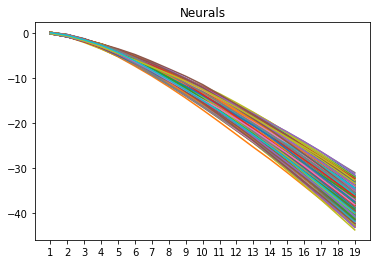

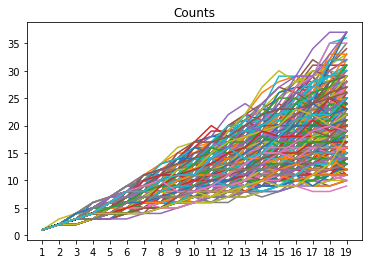

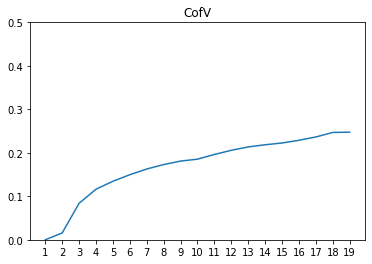

In [5]:
# Tests
model_type = MODEL_TYPES.LOG
betas = [1, 1.5, 0, 0.5]
target_nums = np.arange(1,20)
n_samps = 1000
continuous = False
mean_pred_cofv = False

model = SymbolicModel(
    model_type=model_type,
    betas=betas,
    noise_stds={
        "neural": 0.062,
        "count":  0,
    },
)

init_neural = model(np.ones(n_samps))
neurals = []
counts =  []
for i in target_nums:
    if i == 1:
        neurals.append(init_neural)
        counts.append(model.decode(neurals[-1]))
    else:
        inc = model(counts[-1]+1)
        neurals.append(neurals[-1]+inc)
        counts.append(model.decode(neurals[-1]-neurals[-2]))
        
    if not continuous:
        counts[-1] = np.round(counts[-1])
    
xticks = target_nums

plt.plot(target_nums, neurals)
plt.title("Neurals")
plt.xticks(xticks)
plt.show()

plt.plot(target_nums, counts)
plt.title("Counts")
plt.xticks(xticks)
plt.show()

if mean_pred_cofv:
    cofv = [x.std()/x.mean() for x in counts]
else:
    cofv = [x.std()/(i+1) for i,x in enumerate(counts)]

plt.plot(target_nums, cofv)
plt.title("CofV")
plt.ylim([0,0.5])
plt.xticks(xticks)
plt.show()

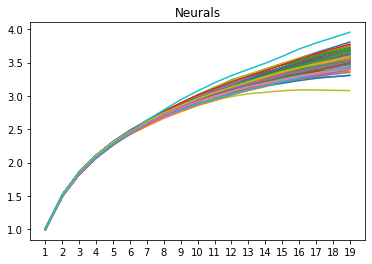

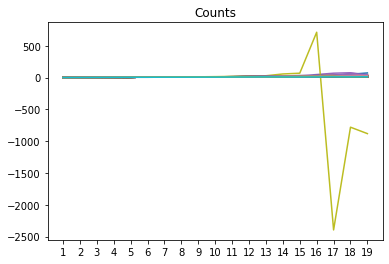

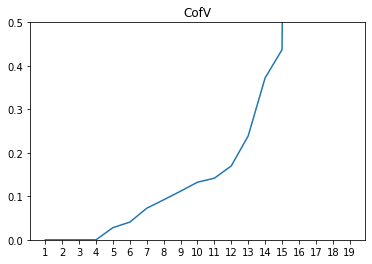

In [6]:
# Tests
model_type = MODEL_TYPES.INVERSE
betas = [1, 1, 0, 1e-3]
target_nums = np.arange(1,20)
n_samps = 100
continuous = False
mean_pred_cofv = False

model = SymbolicModel(
    model_type=model_type,
    betas=betas,
    noise_stds={
        "neural": 0.005,
        "count":  0,
    },
)

init_neural = model(np.ones(n_samps))
neurals = []
counts =  []
for i in target_nums:
    if i == 1:
        neurals.append(init_neural)
        counts.append(model.decode(neurals[-1]))
    else:
        inc = model(counts[-1]+1)
        neurals.append(neurals[-1]+inc)
        counts.append(model.decode(neurals[-1]-neurals[-2]))
        
    if not continuous:
        counts[-1] = np.round(counts[-1])
    
xticks = target_nums

plt.plot(target_nums, neurals)
plt.title("Neurals")
plt.xticks(xticks)
plt.show()

plt.plot(target_nums, counts)
plt.title("Counts")
plt.xticks(xticks)
plt.show()

if mean_pred_cofv:
    cofv = [x.std()/x.mean() for x in counts]
else:
    cofv = [x.std()/(i+1) for i,x in enumerate(counts)]

plt.plot(target_nums, cofv)
plt.title("CofV")
plt.ylim([0,0.5])
plt.xticks(xticks)
plt.show()

In [268]:
## Tests
#model_type = MODEL_TYPES.LOG
#betas = [1, 0, 0]
#target_nums = np.arange(1,20)
#n_samps = 1000
#continuous = False
#mean_pred_cofv = True
#
#for std in np.linspace(0.01, 0.5, 20):
#    print("STD:", std)
#    model = SymbolicModel(
#        model_type=model_type,
#        betas=betas,
#        noise_stds={
#            "neural": std,
#            "count":  0,
#        },
#    )
#    
#    init_neural = model(np.ones(n_samps))
#    neurals = []
#    counts =  []
#    for i in target_nums:
#        if i == 1:
#            neurals.append(init_neural)
#        else:
#            inc = model.decode(model(np.ones(n_samps)))
#            neurals.append(model(counts[-1]+inc))
#        if continuous:
#            counts.append(model.decode(neurals[-1]))
#        else:
#            counts.append(np.round(model.decode(neurals[-1])))
#    plt.plot(target_nums, neurals)
#    plt.show()
#    
#    plt.plot(target_nums, counts)
#    plt.show()
#    
#    if mean_pred_cofv:
#        cofv = [x.std()/x.mean() for x in counts]
#    else:
#        cofv = [x.std()/(i+1) for i,x in enumerate(counts)]
#    
#    plt.plot(target_nums, cofv)
#    #plt.ylim([0,0.2])
#    plt.show()

In [357]:
def count_up_count_down(model, target_num, continuous=False, n_samps=1):
    """
    This function uses the model to first count up target_num steps
    and then count down till the model reaches 0

    Args:
        model: SymbolicModel
        target_num: int
            the maximum count
        continuous: bool
            if true, will use a continuous representation of the count.
            if false, will use a discrete representation of the count.
        n_samps: int
            the number of samples to run

    Returns:
        dict(
            up_count: ndarray (n_samps,)
                the model's counting value after target_num steps
            down_count: ndarray (n_samps,)
                the number of steps taken to reach zero stepping down
                from up_count
            history: dict
                "neural": dict
                    "up": list of ndarray [(n_samps,), ...]
                        the neural history during the count up phase
                    "down": list of ndarray [(n_samps,), ...]
                        the neural history during the count down phase
                "count": dict
                    "up": list of ndarray [(n_samps,), ...]
                        the count history during the count up phase
                    "down": list of ndarray [(n_samps,), ...]
                        the count history during the count down phase
    """
    count = np.zeros((n_samps,))
    neural = model(np.ones(n_samps,))
    
    up_neurals = []
    up_counts =  []
    for i in range(1, target_num+1):
        if i == 1:
            up_neurals.append(neural)
            up_counts.append(model.decode(up_neurals[-1]))
        else:
            inc = model(up_counts[-1]+1)
            up_neurals.append(up_neurals[-1]+inc)
            up_counts.append(model.decode(up_neurals[-1]-up_neurals[-2]))
            
        if not continuous:
            up_counts[-1] = np.round(up_counts[-1])
            
    up_count = up_counts[-1].copy()
    up_neural = up_neurals[-1].copy()

    # Count Down
    down_count = np.zeros_like(up_count) - 1
    down_neural = np.zeros_like(down_count)
    down_counts =  [ up_counts[-1] ]
    down_neurals = [ up_neurals[-1] ]
    loop = 1
    while np.any(down_counts[-1]>0) and loop < target_num*2+20:
        dec = model( down_counts[-1] )
        down_neurals.append( down_neurals[-1] - dec )
        
        down_counts.append( model.decode(dec)-1 )
        if not continuous:
            down_counts[-1] = np.round(down_counts[-1])
            
        idx = (down_counts[-1]<=0)&(down_count==-1)
        down_count[idx] = loop
        down_neural[idx] = down_neurals[-1][idx]
        loop += 1
        
    history = {
        "neural": { "up": up_neurals, "down": down_neurals },
        "count":  { "up": up_counts, "down": down_counts }
    }

    return {
        "up_count": up_count,
        "up_neural": up_neural,
        "down_count": down_count,
        "down_neural": down_neural,
        "history": history,
    }



# Experiments

In [372]:
model_type = MODEL_TYPES.LOG
betas = [1, 1.5, 0, 0.5]
stds = [0.1, 0.03, 0.06, 0.02]
target_nums = np.arange(1,20)
n_samps = 1000

In [373]:
df_dict = {
    "std": [],
    
    "up_count": [],
    "down_count": [],
    "up_neural": [],
    "down_neural": [],
    
    "up_count_std": [],
    "down_count_std": [],
    "up_neural_std": [],
    "down_neural_std": [],
    
    "target_num": [],
    "continuous": [],
    "n_samps": [],
}
for std in stds:
    noise_stds = {NOISE_TYPES.NEURAL: std}
    for targ in target_nums:
        model = SymbolicModel(
            model_type=model_type,
            betas=betas,
            noise_stds=noise_stds
        )
        for cont in [True, False]:
            ret_dict = count_up_count_down(
                model,
                target_num=targ,
                continuous=cont,
                n_samps=n_samps
            )
            df_dict["up_count"].append(ret_dict["up_count"].mean())
            df_dict["down_count"].append(ret_dict["down_count"].mean())
            df_dict["up_neural"].append(ret_dict["up_neural"].mean())
            df_dict["down_neural"].append(ret_dict["down_neural"].mean())
            
            df_dict["up_count_std"].append(ret_dict["up_count"].std())
            df_dict["down_count_std"].append(ret_dict["down_count"].std())
            df_dict["up_neural_std"].append(ret_dict["up_neural"].std())
            df_dict["down_neural_std"].append(ret_dict["down_neural"].std())
            
            df_dict["std"].append(std)
            df_dict["target_num"].append(targ)
            df_dict["continuous"].append(cont)
            df_dict["n_samps"].append(n_samps)

/tmp/ipykernel_935927/2034612126.py:57: RuntimeWarning: invalid value encountered in log
  log_x = - beta[0] * np.log(beta[1]*x + beta[2]) + beta[3]
/tmp/ipykernel_935927/2034612126.py:57: RuntimeWarning: divide by zero encountered in log
  log_x = - beta[0] * np.log(beta[1]*x + beta[2]) + beta[3]


In [374]:
df = pd.DataFrame(df_dict)
df["up_cofv"] = df["up_count_std"]/df["up_count"]
df["down_cofv"] = df["down_count_std"]/df["down_count"]
df.head()

,std,up_count,down_count,up_neural,down_neural,up_count_std,down_count_std,up_neural_std,down_neural_std,target_num,continuous,n_samps,up_cofv,down_cofv
0,0.1,1.008180,1.498,0.091019,-1.141338,0.139420,0.499996,0.097794,1.393331,1,True,1000,0.138289,0.333776
1,0.1,1.000000,1.002,0.095929,0.000063,0.000000,0.044677,0.099272,0.141329,1,False,1000,0.000000,0.044587
2,0.1,2.030000,2.530,-0.510992,-0.842308,0.326020,0.580603,0.185963,1.024375,2,True,1000,0.160601,0.229487
3,0.1,2.045000,2.087,-0.504964,0.100647,0.298287,0.481073,0.150138,0.411528,2,False,1000,0.145862,0.230509
4,0.1,3.085226,3.612,-1.523076,-0.743941,0.561379,0.851737,0.281673,1.305187,3,True,1000,0.181957,0.235808


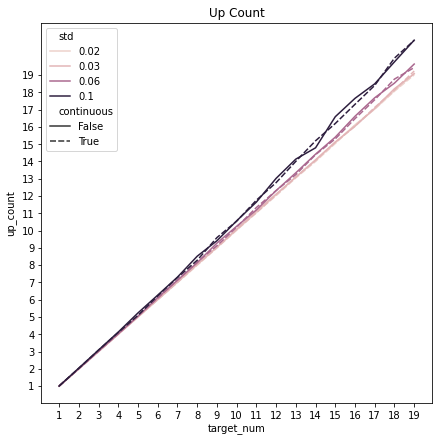

In [375]:
fig = plt.figure(figsize=(7,7))
sns.lineplot(x="target_num", y="up_count", hue="std", style="continuous", data=df)
plt.title("Up Count")
plt.xticks(np.arange(1,np.max(df["target_num"])+1))
plt.yticks(np.arange(1,np.max(df["target_num"])+1))
plt.show()

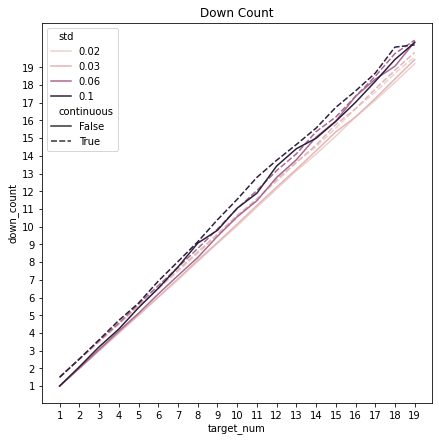

In [376]:
fig = plt.figure(figsize=(7,7))
sns.lineplot(x="target_num", y="down_count", hue="std", style="continuous", data=df)
plt.title("Down Count")
plt.xticks(np.arange(1,np.max(df["target_num"])+1))
plt.yticks(np.arange(1,np.max(df["target_num"])+1))
plt.show()

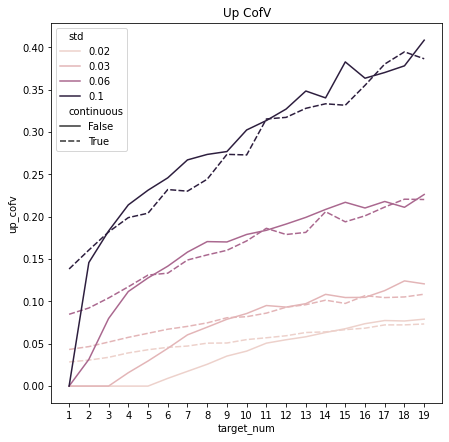

In [377]:
fig = plt.figure(figsize=(7,7))
sns.lineplot(x="target_num", y="up_cofv", hue="std", style="continuous", data=df)
plt.title("Up CofV")
plt.xticks(np.arange(1,np.max(df["target_num"])+1))
plt.show()

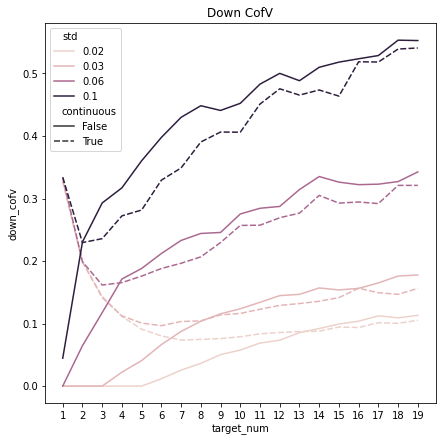

In [378]:
fig = plt.figure(figsize=(7,7))
sns.lineplot(x="target_num", y="down_cofv", hue="std", style="continuous", data=df)
plt.title("Down CofV")
plt.xticks(np.arange(1,np.max(df["target_num"])+1))
plt.show()